In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import pickle
from utils_dump_load import load_from_pickle, dump_to_pickle

<h1> Load metrics from pickle

In [2]:
import pickle
from utils_dump_load import load_from_pickle, dump_to_pickle

In [3]:
filename = "data/data.pkl"
content = load_from_pickle(filename)

In [4]:
X_train = content["X_train"]
X_test = content["X_test"]
y_train = content["y_train"]
y_test = content["y_test"]

In [5]:
filename = "data/metrics.pkl"
metrics = load_from_pickle(filename)

In [6]:
[y_score_lr, precision_lr, recall_lr, threshold_lr] = metrics["lr"]
[y_score_xg, precision_xg, recall_xg, threshold_xg] = metrics["xgboost"]
[y_score_lg, precision_lg, recall_lg, threshold_lg] = metrics["lgbm"]
[y_score_g, precision_g, recall_g, threshold_g] = metrics["gauss"]
[y_score_if, precision_if, recall_if, threshold_if] = metrics["if"]

<h1> Cost functions

<h2> Threshold adjustment

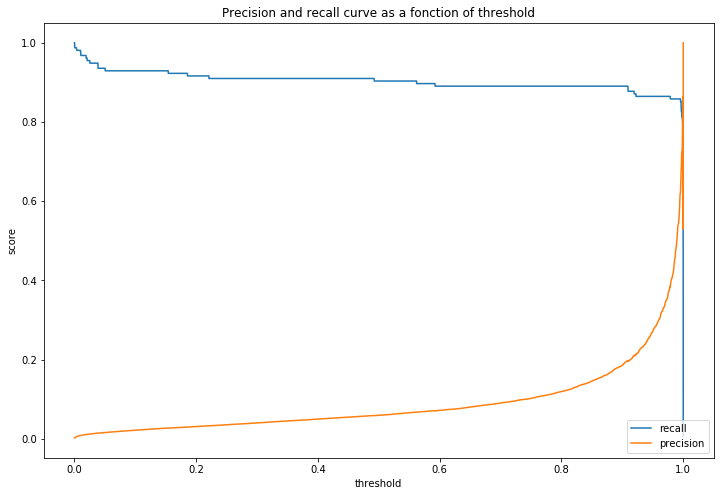

In [7]:
plt.figure(figsize=(12,8))
plt.plot(threshold_lg, recall_lg[:-1], label="recall")
plt.plot(threshold_lg, precision_lg[:-1], label="precision")
plt.xlabel('threshold')
plt.ylabel('score')
plt.title("Precision and recall curve as a fonction of threshold")
plt.legend(loc="lower right")
plt.show()

<h2> Cost evaluation

In [8]:
check_cost_u = 2000
additional_cost_u = 10000

In [9]:
threshold = 0.9

In [10]:
def make_prediction(y_score, threshold):
    y_fraud = np.zeros(len(y_score))
    y_fraud[y_score < threshold] = 0
    y_fraud[y_score >= threshold] = 1
    return y_fraud

In [11]:
y_fraud = make_prediction(y_score_lg[:,1], threshold=0.5)
len(y_fraud), sum(y_fraud)

(85443, 2345.0)

<h3> Cost of fraudulent transaction with algo checking

In [12]:
check_cost = y_fraud.sum() * check_cost_u
check_cost

4690000.0

In [13]:
remaining_fraud_cost = X_test["Amount"][y_test-y_fraud == 1].sum()
remaining_fraud_cost

944.14

In [14]:
additional_cost = len(y_test[y_test-y_fraud == 1]) * additional_cost_u
additional_cost

150000

In [15]:
total_check_cost = check_cost + remaining_fraud_cost + additional_cost
total_check_cost

4840944.14

In [16]:
def check_cost(y_pred, check_cost_u, additional_cost_u):
    check_cost = y_pred.sum() * check_cost_u
    remaining_fraud_cost = X_test["Amount"][y_test-y_pred == 1].sum()
    additional_cost = len(y_test[y_test-y_pred == 1]) * additional_cost_u
    return check_cost + remaining_fraud_cost + additional_cost

In [17]:
check_cost(y_fraud, check_cost_u, additional_cost_u)

4840944.14

<h3> Cost of fraudulent transaction without algo checking

In [18]:
def actual_cost(additional_cost_u):
    remaining_fraud_cost = X_test["Amount"][y_test == 1].sum()
    additional_cost = len(y_test[y_test == 1]) * additional_cost_u
    return remaining_fraud_cost + additional_cost

In [19]:
actual_cost(additional_cost_u)

1569062.37

<h3> Gain

In [20]:
remaining_fraud_cost = X_test["Amount"][y_test == 1].sum()
remaining_fraud_cost

19062.370000000003

In [21]:
additional_cost = len(y_test[y_test == 1]) * additional_cost_u
additional_cost

1550000

In [22]:
total_actual_cost = remaining_fraud_cost + additional_cost
total_actual_cost

1569062.37

In [23]:
gain = total_actual_cost - total_check_cost
gain

-3271881.7699999996

In [24]:
def gain(y_score, threshold, check_cost_u=200, additional_cost_u=1000):
    y_pred = make_prediction(y_score, threshold)
    total_check_cost = check_cost(y_pred, check_cost_u, additional_cost_u)
    total_actual_cost = actual_cost(additional_cost_u)
    return total_actual_cost - total_check_cost

In [25]:
gain(y_score_lg[:,1], threshold=0.3)

-539464.38

In [26]:
thresholds = np.arange(30, 980)/1000

In [34]:
f = lambda t: gain(y_score_xg[:,1], t)
gain = list(map(f, thresholds))
len(gain), max(gain)

(950, 116909.70999999999)

<h3> Plot gain function of threshold

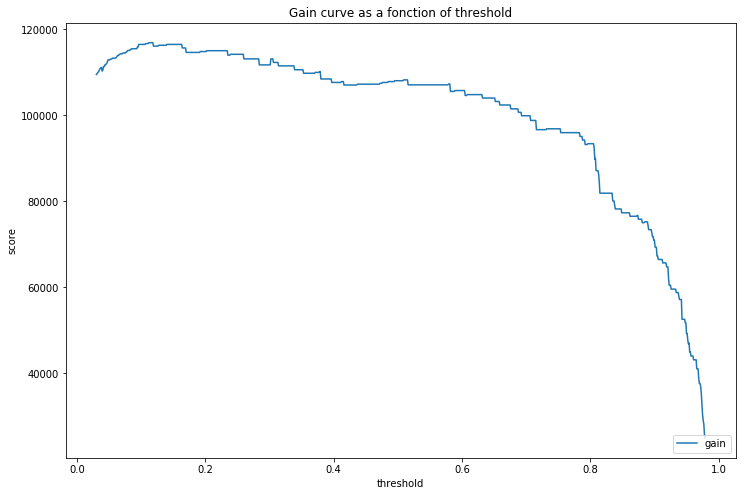

In [35]:
plt.figure(figsize=(12,8))
plt.plot(thresholds, gain, label="gain")
plt.xlabel('threshold')
plt.ylabel('score')
plt.title("Gain curve as a fonction of threshold")
plt.legend(loc="lower right")
plt.show()